In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


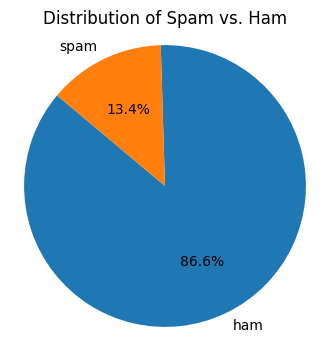

In [6]:
category_counts = df['Category'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')
plt.show()

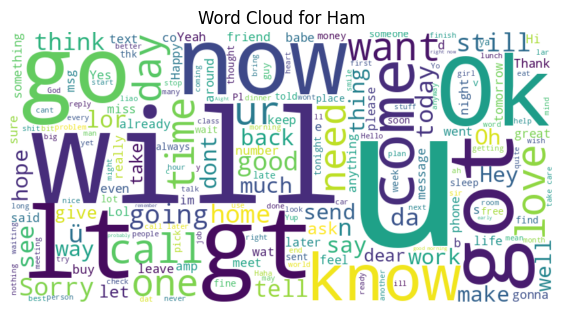

In [8]:
filtered_df = df[df['Category'] == 'ham']

text = ' '.join(filtered_df['Message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(7, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Word Cloud for Ham')
plt.axis('off')
plt.show()

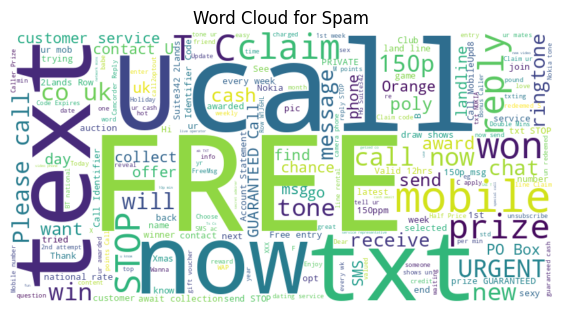

In [9]:
filtered_df = df[df['Category'] == 'spam']

text = ' '.join(filtered_df['Message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(7, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Word Cloud for Spam')
plt.axis('off')
plt.show()

In [10]:
le = LabelEncoder()
df['Category']=le.fit_transform(df['Category'])
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Text Preprocessing
df['Message'] = df['Message'].str.lower()
df['Message'] = df['Message'].str.strip()

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()
df['Message'] = df['Message'].apply(remove_html_tags)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)
df['Message'] = df['Message'].apply(remove_urls)

punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))
df['Message'] = df['Message'].apply(remove_punctuation)

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    clean_text = re.sub(pattern, '', text)
    return clean_text
df['Message'] = df['Message'].apply(remove_special_characters)

def remove_numeric(text):
    return re.sub(r'\d+', '', text)
df['Message'] = df['Message'].apply(remove_numeric)

def remove_non_alphanumeric(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)
df['Message'] = df['Message'].apply(remove_non_alphanumeric)

chat_words = {
    "AFAIK": "As Far As I Know", "AFK": "Away From Keyboard", "ASAP": "As Soon As Possible", "ATK": "At The Keyboard", "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace", "BAK": "Back At Keyboard", "BBL": "Be Back Later", "BBS": "Be Back Soon", "BFN": "Bye For Now",
    "B4N": "Bye For Now", "BRB": "Be Right Back", "BRT": "Be Right There", "BTW": "By The Way", "B4": "Before", "CU": "See You", "W8": "Wait...",
    "CUL8R": "See You Later", "CYA": "See You", "FAQ": "Frequently Asked Questions", "FC": "Fingers Crossed", "FWIW": "For What It's Worth",
    "FYI": "For Your Information", "GAL": "Get A Life", "GG": "Good Game", "GN": "Good Night", "GMTA": "Great Minds Think Alike", "GR8": "Great!",
    "G9": "Genius", "IC": "I See", "ICQ": "I Seek you (also a chat program)", "ILU": "ILU: I Love You", "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion", "IOW": "In Other Words", "IRL": "In Real Life", "KISS": "Keep It Simple, Stupid", "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off", "LOL": "Laughing Out Loud", "LTNS": "Long Time No See", "L8R": "Later", "MTE": "My Thoughts Exactly", "M8": "Mate",
    "NRN": "No Reply Necessary", "OIC": "Oh I See", "PITA": "Pain In The A..", "PRT": "Party", "PRW": "Parents Are Watching", "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing", "ROFLOL": "Rolling On The Floor Laughing Out Loud", "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate", "STATS": "Your sex and age", "ASL": "Age, Sex, Location", "THX": "Thank You", "TTFN": "Ta-Ta For Now!", "TTYL": "Talk To You Later",
    "U": "You", "U2": "You Too", "U4E": "Yours For Ever", "WB": "Welcome Back", "WTF": "What The F...", "WTG": "Way To Go!", "WUF": "Where Are You From?",
    "7K": "Sick:-D Laugher", "TFW": "That feeling when", "MFW": "My face when", "MRW": "My reaction when", "IFYP": "I feel your pain", "JK": "Just kidding",
    "TNTL": "Trying not to laugh", "IDC": "I don't care", "IMU": "I miss you", "ADIH": "Another day in hell", "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here", "TIME": "Tears in my eyes", "BAE": "Before anyone else", "FIMH": "Forever in my heart", "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter", "BFF": "Best friends forever", "CSL": "Can't stop laughing"
}
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)
df['Message'] = df['Message'].apply(replace_chat_words)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
df['Message'] = df['Message'].apply(remove_stopwords)

porter_stemmer = PorterStemmer()
df['Message_stemmed'] = df['Message'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))

<ipython-input-11-08b1b9f68d0c>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
df.head()

,Category,Message,Message_stemmed
0,0,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,0,ok lar joking wif u oni,ok lar joke wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...,free entri wkli comp win fa cup final tkt st m...
3,0,u dun say early hor u c already say,u dun say earli hor u c alreadi say
4,0,nah dont think goes usf lives around though,nah dont think goe usf live around though


In [13]:
cv = CountVectorizer()
X = cv.fit_transform(df['Message_stemmed']).toarray()
y = df['Category']

X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [16]:
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(X_train, y_train)
mnb_pred = mnb_model.predict(X_test)

In [17]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

In [18]:
mnb_accuracy = accuracy_score(y_test, mnb_pred)
mnb_precision = precision_score(y_test, mnb_pred, average='weighted')
mnb_recall = recall_score(y_test, mnb_pred, average='weighted')
mnb_conf_matrix = confusion_matrix(y_test, mnb_pred)
print("Multinomial Naive Bayes:")
print(f"The accuracy score of MultinomialNB is {mnb_accuracy}, The Precision Score is {mnb_precision},The Recall Score is {mnb_recall}")
print(f"The Confusion matrix is \n{mnb_conf_matrix}")
print("\n")

gnb_accuracy = accuracy_score(y_test, gnb_pred)
gnb_precision = precision_score(y_test, gnb_pred, average='weighted')
gnb_recall = recall_score(y_test, gnb_pred, average='weighted')
gnb_conf_matrix = confusion_matrix(y_test, gnb_pred)
print("Gaussian Naive Bayes:")
print(f"The accuracy score of GaussianNB is {gnb_accuracy}, The Precision Score is {gnb_precision},The Recall Score is {gnb_recall}")
print(f"The Confusion matrix is \n{gnb_conf_matrix}")

Multinomial Naive Bayes:
The accuracy score of MultinomialNB is 0.9704035874439462, The Precision Score is 0.9722449920316208,The Recall Score is 0.9704035874439462
The Confusion matrix is 
[[942  24]
 [  9 140]]


Gaussian Naive Bayes:
The accuracy score of GaussianNB is 0.8565022421524664, The Precision Score is 0.9109682235538271,The Recall Score is 0.8565022421524664
The Confusion matrix is 
[[825 141]
 [ 19 130]]


In [20]:
import pickle as pk
from google.colab import files

pk.dump(mnb_model, open('model.pkl', 'wb'))
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>